<a href="https://colab.research.google.com/github/gjoni/trDesign/blob/master/02-GD/notebooks/SI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/1QYS.pdb
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/6MRR.pdb
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/utils.py
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/models.py
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/models.zip
unzip -qqo models.zip

In [2]:
import numpy as np
import matplotlib.pylab as plt
from utils import *
from models import *

## OPTIMIZER TEST

## TOP7

In [3]:
pdb = prep_input("1QYS.pdb")
_feat = pdb["feat"][None]
_seq = np.eye(20)[AA_to_N(pdb["seq"])[0]][None,None]

In [20]:
# setup model for design
# using diag=0.0, since this is what is used in the MCMC run
model = mk_design_model(add_pdb=True, diag=0.0)

mode: single sequence design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [5]:
pred = model.predict(inputs={"I":_seq,"pdb":_feat}, weights={}, train=False)

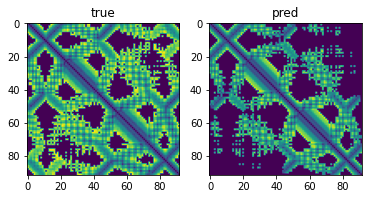

In [6]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.title("true"); plt.imshow(split_feat(_feat[0])["dist"].argmax(-1))
plt.subplot(1,2,2); plt.title("pred"); plt.imshow(split_feat(pred["feat"][0])["dist"].argmax(-1))

In [7]:
wt_line = pred["loss"][0,0]
wt_line

1.5157034

In [8]:
top7_GD = []
for k in range(5):
  top7_GD.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

10 loss:{'pdb':1.581263}
20 loss:{'pdb':1.4181377}
30 loss:{'pdb':1.2930902}
40 loss:{'pdb':1.2825722}
50 loss:{'pdb':1.3011999}
60 loss:{'pdb':1.3235788}
70 loss:{'pdb':1.277347}
80 loss:{'pdb':1.2799728}
90 loss:{'pdb':1.2730888}
100 loss:{'pdb':1.3035456}
110 loss:{'pdb':1.2663996}
120 loss:{'pdb':1.2957507}
130 loss:{'pdb':1.2644638}
140 loss:{'pdb':1.2744981}
150 loss:{'pdb':1.2772464}
160 loss:{'pdb':1.2796454}
170 loss:{'pdb':1.2618406}
180 loss:{'pdb':1.2635651}
190 loss:{'pdb':1.2644238}
200 loss:{'pdb':1.2549001}
FINAL loss:{'pdb':1.2534574}
10 loss:{'pdb':1.5188113}
20 loss:{'pdb':1.3721732}
30 loss:{'pdb':1.4349974}
40 loss:{'pdb':1.3486357}
50 loss:{'pdb':1.2847457}
60 loss:{'pdb':1.2699995}
70 loss:{'pdb':1.27858}
80 loss:{'pdb':1.2716067}
90 loss:{'pdb':1.2672918}
100 loss:{'pdb':1.2877691}
110 loss:{'pdb':1.2775763}
120 loss:{'pdb':1.3250859}
130 loss:{'pdb':1.2842574}
140 loss:{'pdb':1.2622811}
150 loss:{'pdb':1.2678057}
160 loss:{'pdb':1.279121}
170 loss:{'pdb':1.2626

In [21]:
top7_GD_decay = []
for k in range(5):
  top7_GD_decay.append(model.design(inputs={"pdb":_feat}, weights={},
                                    opt_iter=100, opt_method="GD_decay"))

10 loss:{'pdb':1.9121971}
20 loss:{'pdb':1.4277705}
30 loss:{'pdb':1.4955388}
40 loss:{'pdb':1.3418956}
50 loss:{'pdb':1.3380231}
60 loss:{'pdb':1.3501858}
70 loss:{'pdb':1.378676}
80 loss:{'pdb':1.40203}
90 loss:{'pdb':1.3567593}
100 loss:{'pdb':1.2920173}
FINAL loss:{'pdb':1.2920173}
10 loss:{'pdb':1.4831626}
20 loss:{'pdb':1.5215335}
30 loss:{'pdb':1.4282295}
40 loss:{'pdb':1.4362853}
50 loss:{'pdb':1.514228}
60 loss:{'pdb':1.3970336}
70 loss:{'pdb':1.3701161}
80 loss:{'pdb':1.3902651}
90 loss:{'pdb':1.3193583}
100 loss:{'pdb':1.2800728}
FINAL loss:{'pdb':1.2800728}
10 loss:{'pdb':1.5409626}
20 loss:{'pdb':1.4140003}
30 loss:{'pdb':1.3985906}
40 loss:{'pdb':1.414755}
50 loss:{'pdb':1.3852564}
60 loss:{'pdb':1.4773039}
70 loss:{'pdb':1.3459644}
80 loss:{'pdb':1.3602899}
90 loss:{'pdb':1.3511691}
100 loss:{'pdb':1.316249}
FINAL loss:{'pdb':1.3148962}
10 loss:{'pdb':1.6770175}
20 loss:{'pdb':1.4703467}
30 loss:{'pdb':1.4378186}
40 loss:{'pdb':1.4243797}
50 loss:{'pdb':1.36944}
60 loss:

In [10]:
model = mk_design_model(add_pdb=True, sample=True, diag=0.0)

mode: single sequence design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [11]:
top7_GD_sample = []
for k in range(5):
  top7_GD_sample.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

10 loss:{'pdb':2.455307}
20 loss:{'pdb':2.2289107}
30 loss:{'pdb':1.7119254}
40 loss:{'pdb':1.4202471}
50 loss:{'pdb':1.3783613}
60 loss:{'pdb':1.3669868}
70 loss:{'pdb':1.3357997}
80 loss:{'pdb':1.3127965}
90 loss:{'pdb':1.296261}
100 loss:{'pdb':1.3128947}
110 loss:{'pdb':1.3228397}
120 loss:{'pdb':1.2943515}
130 loss:{'pdb':1.2749836}
140 loss:{'pdb':1.2729825}
150 loss:{'pdb':1.2883966}
160 loss:{'pdb':1.2759758}
170 loss:{'pdb':1.2822367}
180 loss:{'pdb':1.2726105}
190 loss:{'pdb':1.2670962}
200 loss:{'pdb':1.2908523}
FINAL loss:{'pdb':1.296111}
10 loss:{'pdb':2.272556}
20 loss:{'pdb':2.3747964}
30 loss:{'pdb':1.6280752}
40 loss:{'pdb':1.3840458}
50 loss:{'pdb':1.3827888}
60 loss:{'pdb':1.3898928}
70 loss:{'pdb':1.3153216}
80 loss:{'pdb':1.3182327}
90 loss:{'pdb':1.3023988}
100 loss:{'pdb':1.2932726}
110 loss:{'pdb':1.2984295}
120 loss:{'pdb':1.287927}
130 loss:{'pdb':1.278183}
140 loss:{'pdb':1.3021301}
150 loss:{'pdb':1.2735865}
160 loss:{'pdb':1.2666297}
170 loss:{'pdb':1.27963

In [19]:
top7_GD_decay_sample = []
for k in range(5):
  top7_GD_decay_sample.append(model.design(inputs={"pdb":_feat}, weights={},
                                           opt_iter=100, opt_method="GD_decay"))

10 loss:{'pdb':2.574353}
20 loss:{'pdb':2.6558712}
30 loss:{'pdb':2.6451423}
40 loss:{'pdb':2.3641782}
50 loss:{'pdb':2.6128817}
60 loss:{'pdb':2.5835636}
70 loss:{'pdb':2.6955404}
80 loss:{'pdb':2.5731807}
90 loss:{'pdb':2.6018038}
100 loss:{'pdb':2.5791736}
FINAL loss:{'pdb':2.0849388}
10 loss:{'pdb':2.642572}
20 loss:{'pdb':2.6098745}
30 loss:{'pdb':2.6673532}
40 loss:{'pdb':2.5645316}
50 loss:{'pdb':2.6544745}
60 loss:{'pdb':2.6436136}
70 loss:{'pdb':2.8115418}
80 loss:{'pdb':2.6069865}
90 loss:{'pdb':2.6840866}
100 loss:{'pdb':2.6497173}
FINAL loss:{'pdb':2.2413654}
10 loss:{'pdb':2.7238255}
20 loss:{'pdb':2.6901329}
30 loss:{'pdb':2.5867734}
40 loss:{'pdb':2.6178381}
50 loss:{'pdb':2.7278512}
60 loss:{'pdb':2.606964}
70 loss:{'pdb':2.6792943}
80 loss:{'pdb':2.5369349}
90 loss:{'pdb':2.817907}
100 loss:{'pdb':2.522982}
FINAL loss:{'pdb':2.2083702}
10 loss:{'pdb':2.7903142}
20 loss:{'pdb':2.6004093}
30 loss:{'pdb':2.5660865}
40 loss:{'pdb':2.5622573}
50 loss:{'pdb':2.6843197}
60 lo

In [14]:
# precomputed MCMC trajectories
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/log_mcmc/mcmc.log
wget -qnc https://files.ipd.uw.edu/krypton/paper2/log_mcmc/seq.txt

In [15]:
log_mcmc = np.loadtxt("mcmc.log")[:,2].reshape(20,-1)/4
seq_mcmc = np.eye(20)[AA_to_N(np.loadtxt("seq.txt",np.str))]
mcmc_line = log_mcmc[:,-1].mean()
mcmc_line

1.2199211239814758

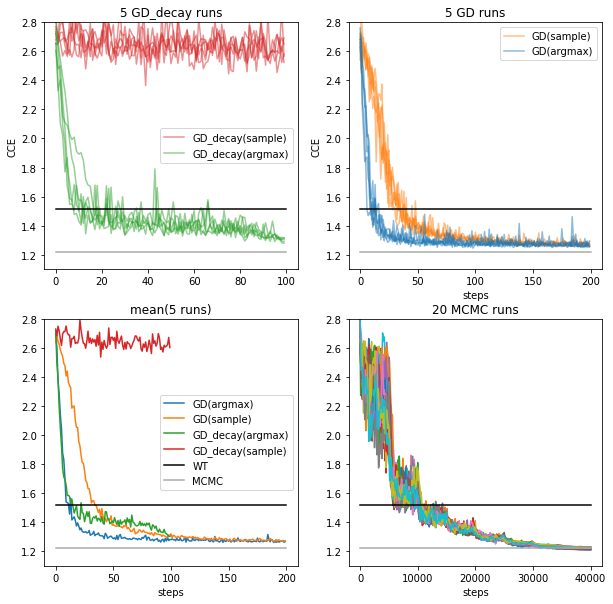

In [37]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("5 GD_decay runs")
for k in range(5):
  label = "GD_decay(sample)" if k == 0 else None
  plt.plot(top7_GD_decay_sample[k]["losses"], label=label,c="tab:red",alpha=0.5)
for k in range(5):
  label = "GD_decay(argmax)" if k == 0 else None
  plt.plot(top7_GD_decay[k]["losses"], label=label,c="tab:green",alpha=0.5)

plt.plot([0,100],[wt_line,wt_line],c="black")
plt.plot([0,100],[mcmc_line,mcmc_line],c="darkgray")
plt.ylim(1.1,2.8)
#plt.xlabel("steps")
plt.ylabel("CCE")
plt.legend()


plt.subplot(2,2,2)
plt.title("5 GD runs")
for k in range(5):
  label = "GD(sample)" if k == 0 else None
  plt.plot(top7_GD_sample[k]["losses"], label=label,c="tab:orange",alpha=0.5)
for k in range(5):
  label = "GD(argmax)" if k == 0 else None
  plt.plot(top7_GD[k]["losses"], label=label,c="tab:blue",alpha=0.5)

plt.plot([0,200],[wt_line,wt_line],c="black")
plt.plot([0,200],[mcmc_line,mcmc_line],c="darkgray")
plt.ylim(1.1,2.8)
plt.xlabel("steps")
plt.ylabel("CCE")
plt.legend()


plt.subplot(2,2,3)
plt.title("mean(5 runs)")
plt.plot(np.mean([top7_GD[k]["losses"] for k in range(5)],0), label="GD(argmax)")
plt.plot(np.mean([top7_GD_sample[k]["losses"] for k in range(5)],0), label="GD(sample)")
plt.plot(np.mean([top7_GD_decay[k]["losses"] for k in range(5)],0), label="GD_decay(argmax)")
plt.plot(np.mean([top7_GD_decay_sample[k]["losses"] for k in range(5)],0), label="GD_decay(sample)")
plt.plot([0,200],[wt_line,wt_line],c="black",label="WT")
plt.plot([0,200],[mcmc_line,mcmc_line],c="darkgray",label="MCMC")
plt.ylim(1.1,2.8)
plt.xlabel("steps")
plt.legend()

plt.subplot(2,2,4); plt.title("20 MCMC runs")
for k in range(20):
  plt.plot(np.linspace(0,40000,401),log_mcmc[k])

plt.plot([0,40000],[wt_line,wt_line],c="black",label="wt")
plt.plot([0,40000],[mcmc_line,mcmc_line],c="darkgray",label="MCMC")
plt.ylim(1.1,2.8)
plt.xlabel("steps")


plt.savefig("top7_cce_compare.png", bbox_inches='tight', dpi=300)
plt.show()

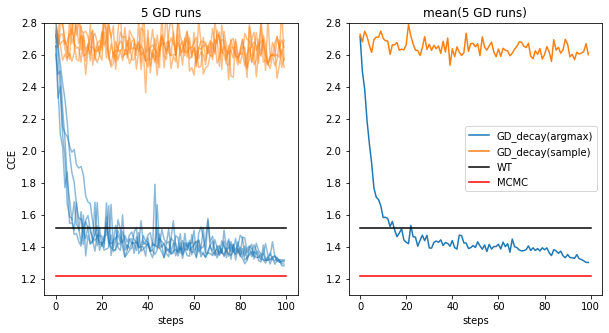

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("5 GD_decay runs")
for k in range(5): plt.plot(top7_GD_decay_sample[k]["losses"], label="GD_decay(sample)",c="tab:orange",alpha=0.5)
for k in range(5): plt.plot(top7_GD_decay[k]["losses"], label="GD_decay(argmax)",c="tab:blue",alpha=0.5)

plt.plot([0,100],[wt_line,wt_line],c="black")
plt.plot([0,100],[mcmc_line,mcmc_line],c="red")
plt.ylim(1.1,2.8)
plt.xlabel("steps")
plt.ylabel("CCE")

plt.subplot(1,2,2)
plt.title("mean(5 GD_decay runs)")
plt.plot(np.mean([top7_GD_decay[k]["losses"] for k in range(5)],0), label="GD_decay(argmax)")
plt.plot(np.mean([top7_GD_decay_sample[k]["losses"] for k in range(5)],0), label="GD_decay(sample)")
plt.plot([0,100],[wt_line,wt_line],c="black",label="WT")
plt.plot([0,100],[mcmc_line,mcmc_line],c="red",label="MCMC")
plt.ylim(1.1,2.8)
plt.xlabel("steps")
plt.legend()

plt.savefig("top7_cce_compare_decay.png", bbox_inches='tight', dpi=300)
plt.show()

## (Linder et al. 2020)

In [ ]:
def funky_kl(true, pred):
  t_feat = split_feat(true)
  p_feat = split_feat(pred)
  kl = 0
  for k in t_feat:
    t = np.clip(t_feat[k], 1e-7, 1. - 1e-7)
    p = p_feat[k]
    t_val = np.sum(t * np.tile(np.reshape(np.arange(t.shape[3]), (1, 1, 1, t.shape[3])), (1, t.shape[1], t.shape[2], 1)), axis=-1) / t.shape[3]
    p_val = np.sum(p * np.tile(np.reshape(np.arange(p.shape[3]), (1, 1, 1, p.shape[3])), (1, p.shape[1], p.shape[2], 1)), axis=-1) / p.shape[3]
    kl += np.mean(t_val * np.log(t_val/p_val))
  return kl

In [ ]:
%%bash
wget -qnc https://github.com/johli/seqprop/raw/master/examples/rosetta/trRosetta/example/T1001_keras_xaa.npz

In [ ]:
# correcting the labels!
npz = np.load("T1001_keras_xaa.npz")
_dist = npz["dist"]
_theta = npz["omega"]
_phi = npz["theta"]
_omega = npz["phi"]
_feat = np.concatenate([_theta,_phi,_dist,_omega],-1)

In [ ]:
# setting up model
model = mk_design_model(add_pdb=True, pdb_kl=True, n_models=1, diag=0.0)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


In [ ]:
# test if we recapitulate the reported score from: Linder et al. 2020
# https://github.com/johli/seqprop/blob/master/examples/rosetta/
# seqprop_rosetta_optimization_eval_layernorm_and_basinhopping_T1001_no_msa_1000_updates_multiple_seeds.ipynb
# kl: 1.2452; funky_kl: 0.1028

seq = "NWDELRKKLKKADSPDEWIKELAKRFPGKKVQVISPGKNGNMPCALLAPDGKPDERKEVCPPPDDDDDDDPPDDQNDNHAPPECQKEMKKQNGKKPKRWICIRDDDGMGQCVVIKKPVPPEELKKIMELIARWSMQMQRH"
_seq = np.eye(20)[AA_to_N(seq)[0]][None,None]
out = model.predict(inputs={"I":_seq,"pdb":_feat}, weights={}, train=False)
print(out["loss"][0,0], funky_kl(_feat, out["feat"]))

1.2452214 0.10283135692232921


In [ ]:
# default optimizer
out_GD_argmax = []
for k in range(5):
  out_GD_argmax.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200, return_traj=True))

10 loss:{'pdb':2.2569094}
20 loss:{'pdb':1.4714473}
30 loss:{'pdb':1.0703315}
40 loss:{'pdb':1.344173}
50 loss:{'pdb':1.0028352}
60 loss:{'pdb':0.9045787}
70 loss:{'pdb':0.675134}
80 loss:{'pdb':0.70066977}
90 loss:{'pdb':0.61174047}
100 loss:{'pdb':0.71796936}
110 loss:{'pdb':0.5702308}
120 loss:{'pdb':0.6057856}
130 loss:{'pdb':0.5638599}
140 loss:{'pdb':0.6813271}
150 loss:{'pdb':0.6015058}
160 loss:{'pdb':0.6020533}
170 loss:{'pdb':0.5267168}
180 loss:{'pdb':0.8018778}
190 loss:{'pdb':0.5334175}
200 loss:{'pdb':0.6775241}
FINAL loss:{'pdb':0.5053733}
10 loss:{'pdb':2.4298377}
20 loss:{'pdb':2.3365266}
30 loss:{'pdb':1.1883755}
40 loss:{'pdb':1.1119425}
50 loss:{'pdb':0.93246424}
60 loss:{'pdb':0.8443508}
70 loss:{'pdb':0.99606466}
80 loss:{'pdb':1.048337}
90 loss:{'pdb':0.7546975}
100 loss:{'pdb':0.75896645}
110 loss:{'pdb':0.68024814}
120 loss:{'pdb':0.6928533}
130 loss:{'pdb':0.686802}
140 loss:{'pdb':0.65045136}
150 loss:{'pdb':0.6607025}
160 loss:{'pdb':0.6302246}
170 loss:{'pd

In [ ]:
# setting up model
model = mk_design_model(add_pdb=True, pdb_kl=True, n_models=1, diag=0.0, sample=True)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


In [ ]:
out_GD_sample = []
for k in range(5):
  out_GD_sample.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200, return_traj=True))

10 loss:{'pdb':3.7002726}
20 loss:{'pdb':3.100686}
30 loss:{'pdb':2.70641}
40 loss:{'pdb':2.14657}
50 loss:{'pdb':1.9249237}
60 loss:{'pdb':1.5418227}
70 loss:{'pdb':1.346905}
80 loss:{'pdb':1.3335599}
90 loss:{'pdb':1.0965273}
100 loss:{'pdb':1.0845035}
110 loss:{'pdb':1.1692432}
120 loss:{'pdb':0.99725705}
130 loss:{'pdb':0.98549974}
140 loss:{'pdb':0.98489857}
150 loss:{'pdb':0.9224693}
160 loss:{'pdb':0.9563236}
170 loss:{'pdb':1.0876349}
180 loss:{'pdb':0.900195}
190 loss:{'pdb':0.87927574}
200 loss:{'pdb':0.84026325}
FINAL loss:{'pdb':0.8574418}
10 loss:{'pdb':3.6308696}
20 loss:{'pdb':3.1835992}
30 loss:{'pdb':2.5227587}
40 loss:{'pdb':2.0917056}
50 loss:{'pdb':1.7514203}
60 loss:{'pdb':1.71309}
70 loss:{'pdb':1.3912586}
80 loss:{'pdb':1.0780891}
90 loss:{'pdb':1.1087236}
100 loss:{'pdb':0.9131594}
110 loss:{'pdb':0.897754}
120 loss:{'pdb':0.88057667}
130 loss:{'pdb':0.87479275}
140 loss:{'pdb':0.86993283}
150 loss:{'pdb':0.92816865}
160 loss:{'pdb':0.78439724}
170 loss:{'pdb':0

In [ ]:
# Note: in manuscript (Linder et al. 2020), they optimize kl, but then plot the "funky" kl for the figure
def get_losses(x, true):
  kl,kl_funky = [],[]
  for k in range(5):
    print(k)
    kl.append([])
    kl_funky.append([])
    for y in x[k]["traj"]:
      kl[-1].append(y["loss"][0])
      kl_funky[-1].append(funky_kl(true, y["feat"]))
  return kl, kl_funky

losses_gd_kl, losses_gd_kl_funky = get_losses(out_GD_argmax, _feat)
losses_gd_kl_sample, losses_gd_kl_funky_sample = get_losses(out_GD_sample, _feat)

0
1
2
3
4
0
1
2
3
4


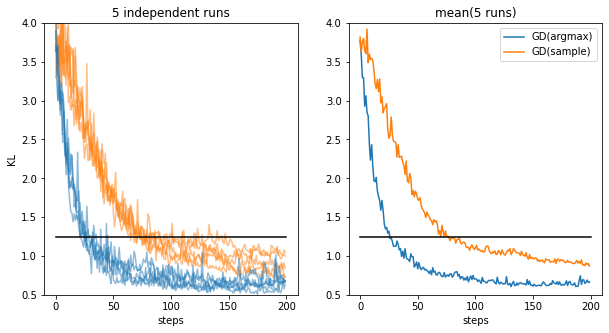

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("5 independent runs")
for k in range(5): plt.plot(np.squeeze(losses_gd_kl_sample)[k], label="GD(argmax)",c="tab:orange",alpha=0.5)
for k in range(5): plt.plot(np.squeeze(losses_gd_kl)[k], label="GD(sample)",c="tab:blue",alpha=0.5)
plt.plot([0,200],[1.2452215,1.2452215],c="black")
plt.ylim(0.5,4.0)
plt.xlabel("steps")
plt.ylabel("KL")

plt.subplot(1,2,2)
plt.title("mean(5 runs)")
plt.plot(np.squeeze(losses_gd_kl).mean(0), label="GD(argmax)")
plt.plot(np.squeeze(losses_gd_kl_sample).mean(0), label="GD(sample)")
plt.plot([0,200],[1.2452215,1.2452215],c="black")
plt.ylim(0.5,4.0)
plt.xlabel("steps")
plt.legend()
plt.savefig("compare.png", bbox_inches='tight', dpi=300)
plt.show()

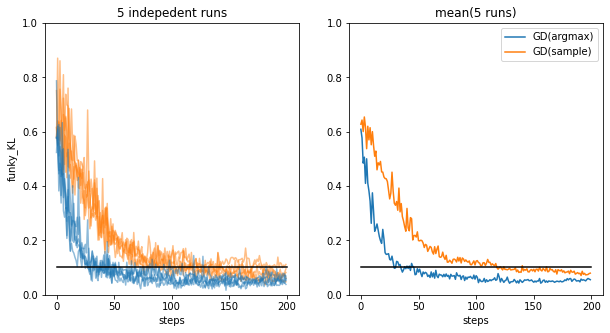

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("5 indepedent runs")
for k in range(5): plt.plot(np.squeeze(losses_gd_kl_funky_sample)[k],c="tab:orange",alpha=0.5)
for k in range(5): plt.plot(np.squeeze(losses_gd_kl_funky)[k],c="tab:blue",alpha=0.5)
plt.plot([0,200],[0.1028,0.1028],c="black")
plt.ylim(0,1.0)
plt.xlabel("steps")
plt.ylabel("funky_KL")

plt.subplot(1,2,2)
plt.title("mean(5 runs)")
plt.plot(np.squeeze(losses_gd_kl_funky).mean(0), label="GD(argmax)")
plt.plot(np.squeeze(losses_gd_kl_funky_sample).mean(0), label="GD(sample)")
plt.plot([0,200],[0.1028,0.1028],c="black")
plt.ylim(0,1.0)
plt.xlabel("steps")
plt.legend()
plt.savefig("compare_funky.png", bbox_inches='tight', dpi=300)
plt.show()

## MSA_DESIGN

In [ ]:
feats = prep_input("6MRR.pdb")
_feat = feats["feat"][None]
_seq = np.eye(20)[AA_to_N(feats["seq"])[0]][None,None]

In [ ]:
model = mk_design_model(add_pdb=True, msa_design=True, feat_drop=0.8, lid=0.3, lid_scale=18.0)

mode: msa design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [ ]:
# design 10,000 sequences for given backbone
out_msa = []
for k in range(5):
  out_msa.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200, num=10000))

10 loss:{'pdb':1.6644279}
20 loss:{'pdb':1.3640765}
30 loss:{'pdb':1.3692967}
40 loss:{'pdb':1.3228083}
50 loss:{'pdb':1.3255063}
60 loss:{'pdb':1.3071893}
70 loss:{'pdb':1.3311455}
80 loss:{'pdb':1.313234}
90 loss:{'pdb':1.3244503}
100 loss:{'pdb':1.2935553}
110 loss:{'pdb':1.3298299}
120 loss:{'pdb':1.2915725}
130 loss:{'pdb':1.3105005}
140 loss:{'pdb':1.2808973}
150 loss:{'pdb':1.2897127}
160 loss:{'pdb':1.3151803}
170 loss:{'pdb':1.3002471}
180 loss:{'pdb':1.2921193}
190 loss:{'pdb':1.3153659}
200 loss:{'pdb':1.3344353}
FINAL loss:{'pdb':1.229383}
10 loss:{'pdb':2.026996}
20 loss:{'pdb':1.4626057}
30 loss:{'pdb':1.3808322}
40 loss:{'pdb':1.335243}
50 loss:{'pdb':1.3630857}
60 loss:{'pdb':1.3524246}
70 loss:{'pdb':1.3283833}
80 loss:{'pdb':1.3709315}
90 loss:{'pdb':1.2974}
100 loss:{'pdb':1.3222393}
110 loss:{'pdb':1.3205761}
120 loss:{'pdb':1.3012199}
130 loss:{'pdb':1.3104955}
140 loss:{'pdb':1.3374249}
150 loss:{'pdb':1.3162217}
160 loss:{'pdb':1.3087548}
170 loss:{'pdb':1.329970

In [ ]:
# switch to PSSM mode
model = mk_design_model(add_pdb=True, pssm_design=True)

mode: pssm design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [ ]:
out_pssm = []
for _ in range(5):
  out_pssm.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

10 loss:{'pdb':1.5977879}
20 loss:{'pdb':1.2415311}
30 loss:{'pdb':1.2395489}
40 loss:{'pdb':1.2185656}
50 loss:{'pdb':1.2032197}
60 loss:{'pdb':1.212906}
70 loss:{'pdb':1.201141}
80 loss:{'pdb':1.2119561}
90 loss:{'pdb':1.192911}
100 loss:{'pdb':1.197251}
110 loss:{'pdb':1.2170228}
120 loss:{'pdb':1.2279361}
130 loss:{'pdb':1.2120682}
140 loss:{'pdb':1.1934869}
150 loss:{'pdb':1.203138}
160 loss:{'pdb':1.2016996}
170 loss:{'pdb':1.2012061}
180 loss:{'pdb':1.1899767}
190 loss:{'pdb':1.2245592}
200 loss:{'pdb':1.1965475}
FINAL loss:{'pdb':1.1876225}
10 loss:{'pdb':1.5567174}
20 loss:{'pdb':1.2895944}
30 loss:{'pdb':1.2241851}
40 loss:{'pdb':1.2268232}
50 loss:{'pdb':1.2039493}
60 loss:{'pdb':1.2065835}
70 loss:{'pdb':1.1947535}
80 loss:{'pdb':1.2162082}
90 loss:{'pdb':1.198225}
100 loss:{'pdb':1.2085539}
110 loss:{'pdb':1.1955119}
120 loss:{'pdb':1.1935556}
130 loss:{'pdb':1.1955539}
140 loss:{'pdb':1.1923896}
150 loss:{'pdb':1.204511}
160 loss:{'pdb':1.2029192}
170 loss:{'pdb':1.198095

In [ ]:
# switch to single sequence mode
model = mk_design_model(add_pdb=True)

mode: single sequence design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [ ]:
out_single = []
for _ in range(5):
  out_single.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

10 loss:{'pdb':2.3291345}
20 loss:{'pdb':1.7911607}
30 loss:{'pdb':1.3845744}
40 loss:{'pdb':1.3563887}
50 loss:{'pdb':1.3235432}
60 loss:{'pdb':1.338437}
70 loss:{'pdb':1.3441833}
80 loss:{'pdb':1.3411521}
90 loss:{'pdb':1.3029509}
100 loss:{'pdb':1.3282019}
110 loss:{'pdb':1.3321358}
120 loss:{'pdb':1.3630509}
130 loss:{'pdb':1.4032018}
140 loss:{'pdb':1.3249786}
150 loss:{'pdb':1.3496944}
160 loss:{'pdb':1.2999715}
170 loss:{'pdb':1.3057218}
180 loss:{'pdb':1.3159086}
190 loss:{'pdb':1.313677}
200 loss:{'pdb':1.3222536}
FINAL loss:{'pdb':1.2787923}
10 loss:{'pdb':2.1057181}
20 loss:{'pdb':1.4050196}
30 loss:{'pdb':1.3556278}
40 loss:{'pdb':1.3596871}
50 loss:{'pdb':1.339384}
60 loss:{'pdb':1.3201519}
70 loss:{'pdb':1.3453481}
80 loss:{'pdb':1.3411759}
90 loss:{'pdb':1.3369172}
100 loss:{'pdb':1.311646}
110 loss:{'pdb':1.3806792}
120 loss:{'pdb':1.3020967}
130 loss:{'pdb':1.3098892}
140 loss:{'pdb':1.2990563}
150 loss:{'pdb':1.31585}
160 loss:{'pdb':1.3355662}
170 loss:{'pdb':1.32916

In [ ]:
wt_loss = model.predict(inputs={"pdb":_feat,"I":_seq},weights={},train=False)["loss"][0,0]
wt_loss

1.6629747

In [ ]:
# score each sequence using TrRosetta single-sequence mode
losses = []
for k in range(5):
  losses.append([])
  for seq in out_msa[k]["I"][:1000]:
    seq = np.eye(20)[seq.argmax(-1)][None,None]
    out = model.predict(inputs={"I":seq,"pdb":_feat}, weights={}, train=False)
    loss = out["loss"][0,0]
    losses[-1].append(loss)

In [ ]:
# pairwise identity
ham = []
for k in range(5):
  msa = out_msa[k]["I"][:1000].argmax(-1)
  ham.append((msa[:,None] == msa[None,:]).mean(-1))
  ham[-1] = ham[-1][np.triu_indices_from(ham[-1],1)]

In [ ]:
def plt_hist(i,bins=30,s=None,e=None,label=None,c=None):
  if s is None: s = np.min(i)
  if e is None: e = np.max(i)
  x,y = np.histogram(i,bins=bins,density=True,range=(s,e))
  y = (y[1:] + y[:-1])/2
  plt.plot(y,x,label=label,c=c)

In [ ]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/6MRR_designs.txt.log.fas
wget -qnc https://files.ipd.uw.edu/krypton/paper2/6MRR.pdb.cf

In [ ]:
def parse_cf(filename, cutoff=0.001):
  # contact Y,1     Y,2     0.006281        MET     ARG
  n,cons = 0, []
  for line in open(filename, "r"):
    line = line.rstrip()
    if line[:7] == "contact":
      _,_,i,_,j,p,_,_ = line.replace(","," ").split()
      i,j,p = int(i),int(j),float(p)
      if i > n: n = i
      if j > n: n = j
      cons.append([i-1,j-1,p])
  cm = np.zeros([n,n])
  for i,j,p in cons: cm[i,j] = p
  return (cm + cm.T)

In [ ]:
names, seqs = parse_fasta("6MRR_designs.txt.log.fas")
msa_ = np.array(AA_to_N(seqs))
cf_ = parse_cf("6MRR.pdb.cf")
msa_s = msa_[:1000]
ham_ = (msa_s[:,None] == msa_s[None,:]).mean(-1)
ham_ = ham_[np.triu_indices_from(ham_,1)]

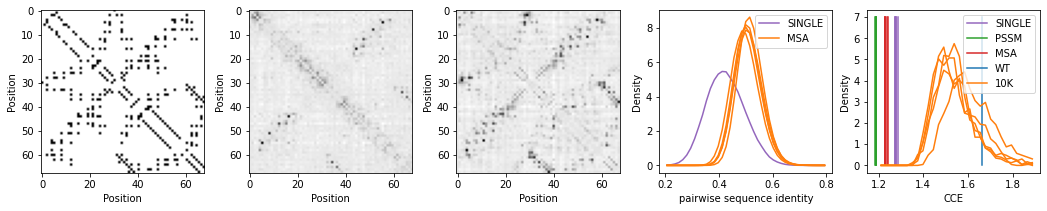

In [ ]:
plt.figure(figsize=(5*3+3,3))

plt.subplot(1,5,1)
plt.imshow(cf_>0.01,cmap="binary")
plt.xlabel("Position"); plt.ylabel("Position")

plt.subplot(1,5,2)
ic = inv_cov(msa_)
plt.imshow(ic,cmap="binary")
plt.xlabel("Position"); plt.ylabel("Position")

plt.subplot(1,5,3)
ic = inv_cov(out_msa[0]["I"].argmax(-1)[:len(msa_)])
plt.imshow(ic,cmap="binary")
plt.xlabel("Position"); plt.ylabel("Position")

plt.subplot(1,5,4)
plt_hist(ham_,bins=41,s=0.2,e=0.8,label="SINGLE",c="tab:purple")
for k in range(5):
  label="MSA" if k == 0 else None
  plt_hist(ham[k],bins=41,c="tab:orange",s=0.2,e=0.8,label=label)
plt.xlabel("pairwise sequence identity")
plt.ylabel("Density")
plt.legend()

plt.subplot(1,5,5)
# single sequence design
for k in range(5):
  label = "SINGLE" if k == 0 else None
  s = out_single[k]["loss"]["pdb"]
  plt.plot([s,s],[0,7],label=label,c="tab:purple")

# pssm design
for k in range(5):
  label = "PSSM" if k == 0 else None
  p = out_pssm[k]["loss"]["pdb"]
  plt.plot([p,p],[0,7],label=label,c="tab:green")

# msa design
for k in range(5):
  m = out_msa[k]["loss"]["pdb"]
  label = "MSA" if k == 0 else None
  plt.plot([m,m],[0,7],label=label,c="tab:red")

# wildtype
w = wt_loss
plt.plot([w,w],[0,7],label="WT")

for k in range(5):
  label = "10K" if k == 0 else None
  plt_hist(losses[k], s=1.2, e=1.9, label=label, c="tab:orange")

plt.legend()
plt.xlabel("CCE")
plt.ylabel("Density")
plt.savefig("fig.png", bbox_inches='tight', dpi=200)

##REDESIGN TEST

In [ ]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/data/redesign_gd.npz.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/data/redesign_gd.pdb.txt

In [ ]:
data_npz_gd = np.loadtxt("redesign_gd.npz.txt",np.str)[:,1:].astype(np.float)
data_pdb_gd = np.loadtxt("redesign_gd.pdb.txt",np.str)[:,1:].astype(np.float)

In [ ]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/scos_ivan.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/denovo_kl_gd_iter100.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/denovo_kl_gd_iter200.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/denovo_kl_gd_sample_iter200.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/denovo_kl_gd_sample_iter400.txt

In [ ]:
def plt_hist(i,bins=30,s=-5,e=-3,label=None):
  x,y = np.histogram(i,bins=bins,density=True,range=(s,e))
  y = (y[1:] + y[:-1])/2
  plt.plot(y,x,label=label)

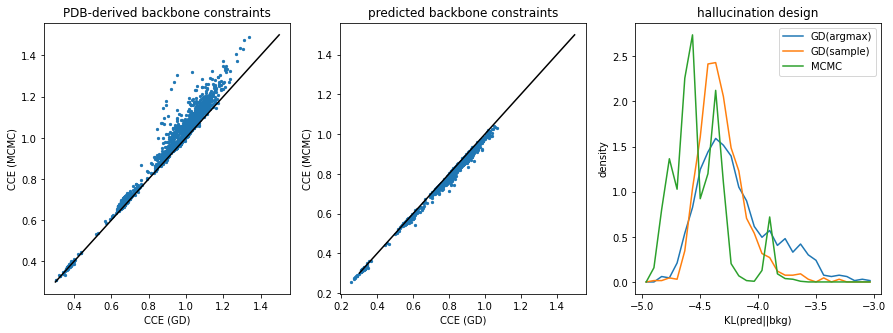

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(data_pdb_gd[:,0],data_pdb_gd[:,2],s=5,cmap="bwr_r")
plt.plot([0.3,1.5],[0.3,1.5],c="black")
plt.title("PDB-derived backbone constraints")
plt.xlabel("CCE (GD)")
plt.ylabel("CCE (MCMC)")

plt.subplot(1,3,2)
plt.scatter(data_npz_gd[:,0],data_npz_gd[:,2],s=5,cmap="bwr_r")
plt.plot([0.3,1.5],[0.3,1.5],c="black")
plt.title("predicted backbone constraints")
plt.xlabel("CCE (GD)")
plt.ylabel("CCE (MCMC)")

plt.subplot(1,3,3)
plt.title("hallucination design")
plt_hist(np.loadtxt("denovo_kl_gd_iter200.txt",np.float),label="GD(argmax)")
plt_hist(np.loadtxt("denovo_kl_gd_sample_iter200.txt",np.float),label="GD(sample)")
plt_hist(np.loadtxt("scos_ivan.txt",np.float)*4,label="MCMC")
plt.ylabel("density")
plt.xlabel("KL(pred||bkg)")
plt.legend()


plt.savefig("mcmc_vs_gd.png", bbox_inches='tight', dpi=300)
plt.show()


##stats

In [49]:
def parse_cf(filename):
  # contact Y,1     Y,2     0.006281        MET     ARG
  n,cons = 0, []
  for line in open(filename, "r"):
    line = line.rstrip()
    if line[:7] == "contact":
      _,_,i,_,j,p,_,_ = line.replace(","," ").split()
      i,j,p = int(i),int(j),float(p)
      if i > n: n = i
      if j > n: n = j
      cons.append([i-1,j-1,p])
  cm = np.zeros([n,n])
  for i,j,p in cons: cm[i,j] = p
  return (cm + cm.T)

def parse_min(filename):
  # 1 T 2 D 3.49406883160592
  n,cons = 0, []
  for line in open(filename, "r"):
    line = line.rstrip()
    i,a,j,b,d = line.replace(","," ").split()
    i,j,d = int(i),int(j),float(d)
    if i > n: n = i
    if j > n: n = j
    cons.append([i-1,j-1,d])
  cm = np.zeros([n,n])
  for i,j,p in cons: cm[i,j] = p
  cm =  (cm + cm.T)
  np.fill_diagonal(cm,np.inf)
  return cm

In [85]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/short_long_designs.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/short_long_designs.pssm.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/short_long_designs.msa08.txt

In [39]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/ss_for_all.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/cf_pdb.zip
wget -qnc https://files.ipd.uw.edu/krypton/paper2/min_dist.zip

unzip -qqo min_dist.zip
unzip -qqo cf_pdb.zip -d native
ls native/*.cf | sed 's/.pdb.cf//g' | sed 's/native\///g' > cf_list


In [50]:
CF,SQ,MN = {},{},{}
for id in np.loadtxt("cf_list",np.str):
  CF[id] = parse_cf(f"native/{id}.pdb.cf")
  MN[id] = parse_min(f"native/{id}.pdb.min.txt")
  SQ[id] = parse_PDB(f"native/{id}.pdb")[-1]

SS = {}
for id,ss,seq in np.loadtxt("ss_for_all.txt",np.str):
  SS[id] = np.array(list(ss))

In [115]:
def get_stats(SQ,MN):
  wt_a = np.zeros(20)
  wt_aa = np.zeros((20,20))
  cpr_a = [[] for _ in range(20)]
  ss_C = np.zeros(20)
  ss_H = np.zeros(20)
  ss_E = np.zeros(20)

  for id in SQ:
    if CF[id].shape[0] == SQ[id].shape[0]:
      cf = CF[id] > 0.01
      mn = MN[id] < 5.0
      seq = SQ[id]
      seq_oh = np.eye(20)[seq]

      mn_ = np.zeros_like(mn)
      sep_idx = np.triu_indices_from(mn,2)
      mn_[sep_idx] = mn[sep_idx]
      mn = mn_ 

      #pw
      wt_a += seq_oh.sum(0)
      wt_aa += np.einsum("ia,jb,ij->ab", seq_oh, seq_oh, mn)

      #cpr
      for c,a in zip(cf,seq):
        cpr_a[a].append(c.sum())

      #ss
      ss_C += np.sum(seq_oh[SS[id] == 'L'],0)
      ss_H += np.sum(seq_oh[SS[id] == 'H'],0)
      ss_E += np.sum(seq_oh[SS[id] == 'S'],0)

  wt_a /= wt_a.sum()
  wt_aa += wt_aa.T
  wt_aa /= wt_aa.sum()
  ss = np.array([ss_C/ss_C.sum(),ss_H/ss_H.sum(),ss_E/ss_E.sum()])
  return {"a":wt_a,
          "pw":np.log(wt_aa/(wt_a[:,None]*wt_a[None,:])),
          "ss":np.log(ss/wt_a),
          "cpr":[np.mean(c) for c in cpr_a],
          "cpr_raw":cpr_a}

In [116]:
wt = get_stats(SQ,MN)

In [117]:
SQ_design,MN_design = {},{}
for id,sq in np.loadtxt("short_long_designs.txt",np.str):
  SQ_design[id] = np.array(AA_to_N(sq)[0])
  MN_design[id] = parse_min(f"native/redesign/SEQ/{id}.pdb.min.txt")

design_seq = get_stats(SQ_design,MN_design)

In [118]:
SQ_design,MN_design = {},{}
for id,sq in np.loadtxt("short_long_designs.pssm.txt",np.str):
  SQ_design[id] = np.array(AA_to_N(sq)[0])
  MN_design[id] = parse_min(f"native/redesign/PSSM/{id}.pdb.min.txt")

design_pssm = get_stats(SQ_design,MN_design)

In [119]:
SQ_design,MN_design = {},{}
for id,sq in np.loadtxt("short_long_designs.msa08.txt",np.str):
  SQ_design[id] = np.array(AA_to_N(sq)[0])
  MN_design[id] = parse_min(f"native/redesign/MSA/{id}.pdb.min.txt")

design_msa = get_stats(SQ_design,MN_design)

In [120]:
idx = [
      13, #F
       9, #I
       10, #L
       19, #V 
       12, #M
       17, #W
       18, #Y
       4, #C
       0,  #A
       3, #D
       6,  #E
       11, #K
       1,  #R
       8, #H
       2,  #N
       5, #Q
       15, #S
       16, #T
       7,  #G
       14, #P
]
np.array(alpha_1)[idx]

array(['F', 'I', 'L', 'V', 'M', 'W', 'Y', 'C', 'A', 'D', 'E', 'K', 'R',
       'H', 'N', 'Q', 'S', 'T', 'G', 'P'], dtype='<U1')

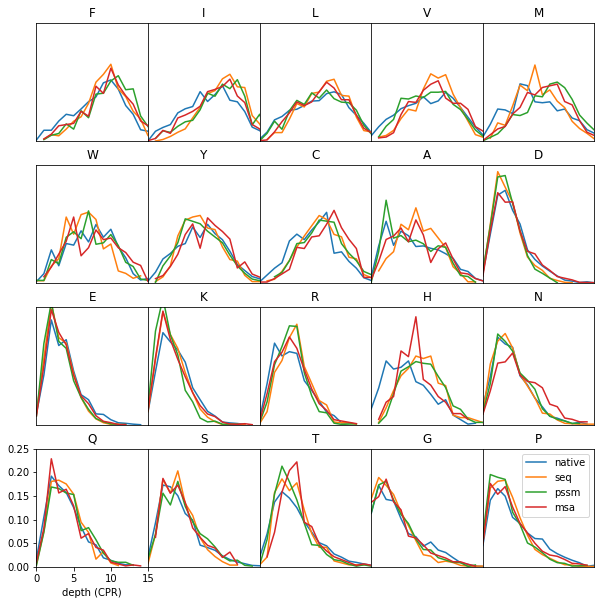

In [121]:
wt_cpr_raw = [np.unique(x,return_counts=True) for x in wt["cpr_raw"]]
design_seq_cpr_raw = [np.unique(x,return_counts=True) for x in design_seq["cpr_raw"]]
design_pssm_cpr_raw = [np.unique(x,return_counts=True) for x in design_pssm["cpr_raw"]]
design_msa_cpr_raw = [np.unique(x,return_counts=True) for x in design_msa["cpr_raw"]]

plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0)
for n in range(20):
  k = idx[n]
  plt.subplot(4,5,n+1)
  plt.title(f"{alpha_1[k]}")
  plt.plot(wt_cpr_raw[k][0],wt_cpr_raw[k][1]/wt_cpr_raw[k][1].sum(),label="native")
  plt.plot(design_seq_cpr_raw[k][0],design_seq_cpr_raw[k][1]/design_seq_cpr_raw[k][1].sum(),label="seq")
  plt.plot(design_pssm_cpr_raw[k][0],design_pssm_cpr_raw[k][1]/design_pssm_cpr_raw[k][1].sum(),label="pssm")
  plt.plot(design_msa_cpr_raw[k][0],design_msa_cpr_raw[k][1]/design_msa_cpr_raw[k][1].sum(),label="msa")
  plt.xlim(0,15)
  plt.ylim(0,0.25)
  if n != 15:
    plt.xticks([])
    plt.yticks([])
  else:
    plt.xlabel("depth (CPR)")
  if n == 19:
    plt.legend()
plt.savefig("cpr_dist.png", bbox_inches='tight', dpi=300)
plt.show()

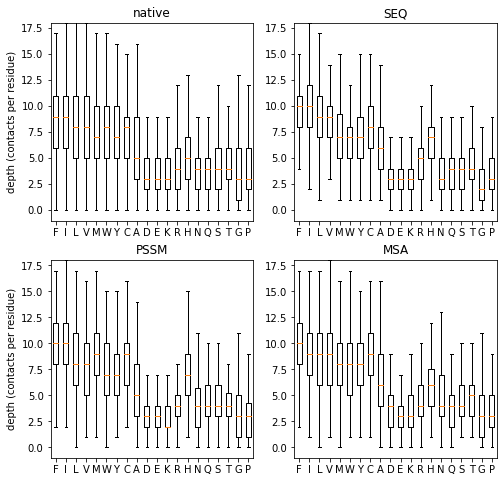

In [122]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1); plt.title("native")
plt.boxplot([wt["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylabel("depth (contacts per residue)")
plt.ylim(-1.0,18.0)

plt.subplot(2,2,2); plt.title("SEQ")
plt.boxplot([design_seq["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylim(-1.0,18.0)

plt.subplot(2,2,3); plt.title("PSSM")
plt.boxplot([design_pssm["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylim(-1.0,18.0)
plt.ylabel("depth (contacts per residue)")

plt.subplot(2,2,4); plt.title("MSA")
plt.boxplot([design_msa["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylim(-1.0,18.0)


plt.savefig("cpr_boxplot.png", bbox_inches='tight', dpi=300)
plt.show()

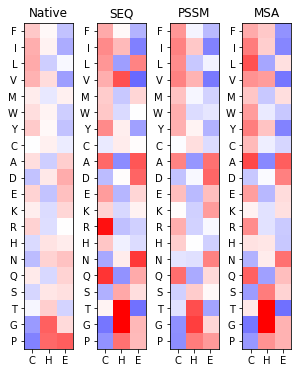

In [123]:
k = idx
vnx = {"cmap":"bwr_r","vmin":-1.5,"vmax":1.5}
plt.figure(figsize=(5,6))
plt.subplot(1,4,1); plt.title("Native")
plt.imshow(wt["ss"][:,idx].T,**vnx)
plt.xticks(np.arange(3), ["C","H","E"]);plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(1,4,2); plt.title("SEQ")
plt.imshow(design_seq["ss"][:,idx].T,**vnx)
plt.xticks(np.arange(3), ["C","H","E"]);plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(1,4,3); plt.title("PSSM")
plt.imshow(design_pssm["ss"][:,idx].T,**vnx)
plt.xticks(np.arange(3), ["C","H","E"]);plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(1,4,4); plt.title("MSA")
plt.imshow(design_msa["ss"][:,idx].T,**vnx)
plt.xticks(np.arange(3), ["C","H","E"]);plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.savefig("SS.png", bbox_inches='tight', dpi=300)
plt.show()


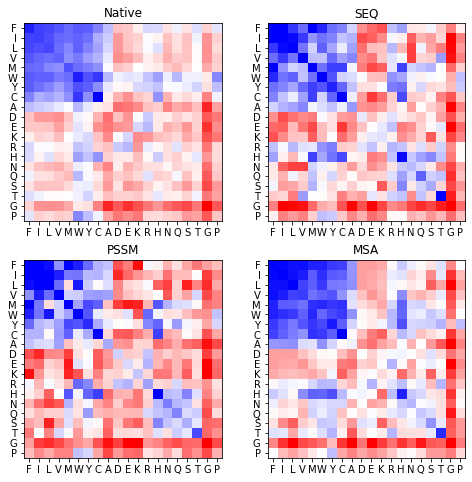

In [124]:
k = idx
plt.figure(figsize=(8,8))

plt.subplot(2,2,1); plt.title("Native")
plt.imshow(wt["pw"][k,:][:,k],**vnx)
plt.xticks(np.arange(20), np.array(alpha_1)[k])
plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(2,2,2); plt.title("SEQ")
plt.imshow(design_seq["pw"][k,:][:,k],**vnx)
plt.xticks(np.arange(20), np.array(alpha_1)[k])
plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(2,2,3); plt.title("PSSM")
plt.imshow(design_pssm["pw"][k,:][:,k],**vnx)
plt.xticks(np.arange(20), np.array(alpha_1)[k])
plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(2,2,4); plt.title("MSA")
plt.imshow(design_msa["pw"][k,:][:,k],**vnx)
plt.xticks(np.arange(20), np.array(alpha_1)[k])
plt.yticks(np.arange(20), np.array(alpha_1)[k])


plt.savefig("PW.png", bbox_inches='tight', dpi=300)
plt.show()


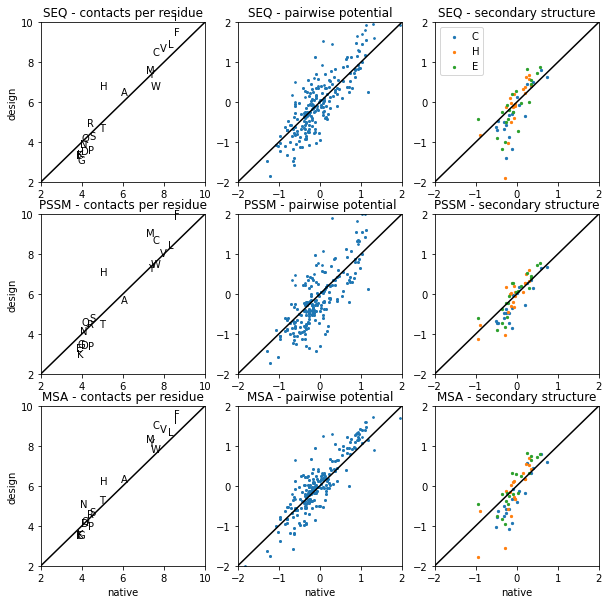

In [126]:
plt.figure(figsize=(10,10))

plt.subplot(3,3,1); plt.title("SEQ - contacts per residue")
for k in range(20): plt.text(x=wt["cpr"][k],y=design_seq["cpr"][k],s=alpha_1[k])
plt.xlim(2,10); plt.ylim(2,10)
plt.plot([2,10],[2,10],c="black")
plt.ylabel("design")

plt.subplot(3,3,2); plt.title("SEQ - pairwise potential")
plt.scatter(wt["pw"],design_seq["pw"],s=3)
plt.xlim(-2,2); plt.ylim(-2,2)
plt.plot([-2,2],[-2,2],c="black")

plt.subplot(3,3,3); plt.title("SEQ - secondary structure")
plt.scatter(wt["ss"][0],design_seq["ss"][0],label="C",s=5)
plt.scatter(wt["ss"][1],design_seq["ss"][1],label="H",s=5)
plt.scatter(wt["ss"][2],design_seq["ss"][2],label="E",s=5)
plt.plot([-2,2],[-2,2],c="black")
plt.xlim([-2,2]);plt.ylim([-2,2])
plt.legend()

plt.subplot(3,3,4); plt.title("PSSM - contacts per residue")
for k in range(20): plt.text(x=wt["cpr"][k],y=design_pssm["cpr"][k],s=alpha_1[k])
plt.xlim(2,10); plt.ylim(2,10)
plt.plot([2,10],[2,10],c="black")
plt.ylabel("design")

plt.subplot(3,3,5); plt.title("PSSM - pairwise potential")
plt.scatter(wt["pw"],design_pssm["pw"],s=3)
plt.xlim(-2,2); plt.ylim(-2,2)
plt.plot([-2,2],[-2,2],c="black")

plt.subplot(3,3,6); plt.title("PSSM - secondary structure")
plt.scatter(wt["ss"][0],design_pssm["ss"][0],label="C",s=5)
plt.scatter(wt["ss"][1],design_pssm["ss"][1],label="H",s=5)
plt.scatter(wt["ss"][2],design_pssm["ss"][2],label="E",s=5)
plt.plot([-2,2],[-2,2],c="black")
plt.xlim([-2,2]);plt.ylim([-2,2])

plt.subplot(3,3,7); plt.title("MSA - contacts per residue")
for k in range(20): plt.text(x=wt["cpr"][k],y=design_msa["cpr"][k],s=alpha_1[k])
plt.xlim(2,10); plt.ylim(2,10)
plt.plot([2,10],[2,10],c="black")
plt.xlabel("native"); plt.ylabel("design")

plt.subplot(3,3,8); plt.title("MSA - pairwise potential")
plt.scatter(wt["pw"],design_msa["pw"],s=3)
plt.xlim(-2,2); plt.ylim(-2,2);
plt.plot([-2,2],[-2,2],c="black")
plt.xlabel("native"); 

plt.subplot(3,3,9); plt.title("MSA - secondary structure")
plt.scatter(wt["ss"][0],design_msa["ss"][0],label="C",s=5)
plt.scatter(wt["ss"][1],design_msa["ss"][1],label="H",s=5)
plt.scatter(wt["ss"][2],design_msa["ss"][2],label="E",s=5)
plt.plot([-2,2],[-2,2],c="black")
plt.xlim([-2,2]);plt.ylim([-2,2])
plt.xlabel("native"); 

plt.savefig("CPR_9plot.png", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
!zip figs.zip *.png

  adding: compare_funky.png (deflated 5%)
  adding: compare.png (deflated 4%)
  adding: CPR_9plot.png (deflated 16%)
  adding: cpr_boxplot.png (deflated 19%)
  adding: fig.png (deflated 6%)
  adding: mcmc_vs_gd.png (deflated 10%)
  adding: PW.png (deflated 21%)
  adding: SS.png (deflated 29%)
  adding: top7_cce_compare.png (deflated 6%)
